<font size=7rem>
ML Model for Check if Covid
</font>

In [1]:
import os
import re
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows=100
pd.options.display.max_columns=100

In [2]:
# Load relative functions
import sys

# this allows you to access the hierarchy
if ".." not in sys.path:
    sys.path.insert(0, '..')

# Smote method
from utils.split_to_train_test import split_and_balance_with_SMOTE

In [3]:
def extract_from_dict(my_dict):
    """Extracts data from a nested structure"""
    if type(my_dict)!=dict:
        my_dict = json.loads(my_dict)
    # Begin extracting values
    new_dict = {}
    for key, value in my_dict.items():
        new_dict[key] = list(value.values())[0]
    
    return new_dict

In [42]:
def get_true_positives_etc(y_actual, y_predict, dict_out=False):
    """
    Calculates true positives, true negatives, etc.
    """
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for y, y_p in zip(y_actual, y_predict):
        if y==y_p==1:
            TP += 1
        if y==y_p==0:
            TN += 1
        if y==0 and y_p==1:
            FP+=1
        if y==1 and y_p==0:
            FN+=1

    # How do you want it formated on output?
    if dict_out:
        return {"TP":TP,"TN":TN, "FP":FP,"FN":FN}
    
    else:
        return (TP, TN, FP, FN)

# Load the data
<font color=red size=4rem><i>
    Copy code from `pre-processing.py`:
</i></font>

In [4]:
data_path = "../data/covid-user-reports 05-20-2020.csv"

df = pd.read_csv(data_path)

# Clean up column names
df.columns = df.columns.str.replace(" \([A-Z]\)","")
df.drop(columns=["SurveyID","UserID"],inplace=True, errors="ignore")

# These columns are fairly straightforward.
# Goal is to dynamically map them to proper structures.
my_columns = [
    'Age',
    'Calendar',
    'Country',
    'CountryCode',
    'Diagnosis',
    'Gender',
    'PostalCode',
    'ReportDate',
    'ReportSource',
    'Symptoms'
]


# Nested dictionaries:
#   The columns contain dictionaries with key value pairs as additional columns.
#   Ex. {"color":"red","shape":"circle"}
nested_cols = ["Calendar","Diagnosis"]
for col in nested_cols:
    df_temp = df[col].apply(extract_from_dict).apply(pd.Series).add_prefix(f"{col}_")
    df = df.merge(df_temp, left_index=True, right_index=True)
    df.drop(columns=col,inplace=True) #dynamically drop them

del df_temp # stay neat


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Flat dictionary – with decoding
#   These are very similar to above, except
#   single quotation mark \' must be substituted for double \"
nested_cols_decoded = ["Symptoms"]
for col in nested_cols_decoded:
    df_temp = df[col].replace({'\'': '"',"True":"true","False":"false"}, regex=True).apply(json.loads).apply(pd.Series).add_prefix(f"{col}_")
    df_temp.fillna(False,inplace=True)
    df = df.merge(df_temp, left_index=True, right_index=True)
    df.drop(columns=col,inplace=True) #dynamically drop them

del df_temp # stay neat

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


# ==============================================================================
# Convert dtypes:
# ==============================================================================

# Q: Should we include the time of day the user filled out the survey?
#   Current method localizes datetime, so is not available without modifying code 1st.

# ------------------------------------------------------------------------------

# Date columns contain "Date" or "Calendar"
dt_columns = [x for x in df.columns if any(y in x for y in ["Date","Calendar"])]
for col in dt_columns:
    df[col] = pd.to_datetime(df[col]).dt.tz_localize(None) # We don't want timezones...

del dt_columns # stay neat

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Converting to categorical data lessens the disk space of the dataframe.
categorical_columns = ["Age","Gender","Country","PostalCode"]
for col in categorical_columns:
    df[col] = pd.Categorical(df[col])

del categorical_columns # stay neat

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Convert diagnosis.
#   Map this dictionary to all relevant columns
d_map = {
    "yes":True,
    "no":False,
    "positive":True,
    "negative":False,
    "waiting for results":None,
    "waiting":None,
    }
# Get the columns
diagnosies_cols = [x for x in df.columns if "Diagnosis" in x]
df[diagnosies_cols] = df[diagnosies_cols].replace(d_map )

# * NOTE: * Eventually, write a test to determine if diagnosis cols were correctly formatted

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Additional columns to ignore? (Manual process...)
drop_cols = ["CountryCode"]
df.drop(columns=drop_cols,inplace=True)

del drop_cols #stay neat


<b>Convert to categoricals:</b>

In [5]:
# Encode Categorical Data
cat_cols = [
    "Age", # Is buckets, good.
    "Country", # Mostly North America
    "Gender", # Male / Female / Non-Binary / Others --> Improper encoding can cause errors
    "ReportSource", # Should be uniform
]

# Use Dummy variables. (Include na – for now)
for col in cat_cols:
    df_temp = pd.get_dummies(df[col], prefix=col, dtype=bool,dummy_na=True)
    df = df.merge(df_temp, left_index=True, right_index=True)
    df.drop(columns=col, inplace=True) #dynamically drop them

del df_temp # stay neat

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Date Diffs
# There should be 3 columns for calendar:
#   * ['Calendar_onset', 'Calendar_subsided', 'Calendar_tested']
#   * Let's asssume these columns aren't renamed at any point
#   * Also, assume there are only 3 columns... (and not more)

dt_columns = [x for x in df.columns if any(y in x for y in ["Date","Calendar"])]
needed_dt_columns = ['Calendar_onset', 'Calendar_subsided', 'Calendar_tested']
custom_dt_columns = ["N_days_Onset_to_Test","N_days_Onset_to_Subside","N_days_Onset_to_Now"]


# Assert these columns exist, otherwise, throw an error
if not all([y for x in dt_columns for y in needed_dt_columns]):
    raise ValueError(
    f"""Datetime columns don't match:
        {needed_dt_columns}
    Current columns:
        {dt_columns}
    Cannot create `custom dt columns`:
        {custom_dt_columns}"""
    )

# Create the new dt columns here
df["N_days_Onset_to_Test"] = (df["Calendar_tested"] - df["Calendar_onset"]).dt.days
df["N_days_Onset_to_Subside"] = (df["Calendar_tested"] - df["Calendar_onset"]).dt.days
df["N_days_Onset_to_Now"] = (df["ReportDate"] - df["Calendar_onset"]).dt.days

# Done with the datetime columns – drop them
df.drop(columns=dt_columns, errors="ignore", inplace=True)

del dt_columns, needed_dt_columns, custom_dt_columns # stay neat

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


<font color=red size=4rem><b>
    Drop all zip codes from death valley <i>(92328)</i>:
</b></font>

In [6]:
# df.drop(df[df["PostalCode"]=="92328"].index, inplace=True)

# Postal codes!
# SKIP FOR NOW
df.drop(columns="PostalCode", errors="ignore", inplace=True)

<font color=red size=4rem><b>
    Drop all non-valid responses:
</b></font>

In [7]:
y_col = "Diagnosis_result"

# Consider dropping all those who haven't been tested:
discrimator_col = "Diagnosis_tested"
df.drop(df[df[discrimator_col]!=True].index, inplace=True) # dropping when not true

# Split + Oversample
<font color=red size=4rem><i>
    Copy from `split_to_train_test.py`
</i></font>

In [8]:
df

,Diagnosis_result,Diagnosis_tested,Symptoms_cough,Symptoms_body_pain,Symptoms_headache,Symptoms_sore_throat,Symptoms_fever,Symptoms_sinus_pressure,Symptoms_diarrhea,Symptoms_chills,Symptoms_runny_nose,Symptoms_fatigue,Symptoms_reduced_smell_taste,Symptoms_asthma,Symptoms_rash,Symptoms_shortness_breath,Symptoms_sneezing,Symptoms_chest_pain,Symptoms_nausea,Age_11-30,Age_31-50,Age_51-70,Age_nan,Country_Canada,Country_United States of America,Country_nan,Gender_female,Gender_male,Gender_nan,ReportSource_report_diagnosis,ReportSource_nan,N_days_Onset_to_Test,N_days_Onset_to_Subside,N_days_Onset_to_Now
0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,39,39,43
1,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False,36,36,74
2,None,True,False,True,False,False,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,0,0,1
3,True,True,False,False,True,False,False,True,False,False,False,True,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,11,11,28
4,False,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,6,6,51
5,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,0,0,1
6,False,True,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,14,14,93
7,True,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,0,0,0
8,None,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,True,False,0,0,1
9,True,True,True,True,False,True,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,0,0,0


In [18]:
# Split
X = df.drop(columns=y_col).astype(int).fillna(0)
y = df[y_col].fillna(0).astype(int)


# Balance with SMOTE
print("* Balancing data with smote")
X_train, X_test, y_train, y_test = split_and_balance_with_SMOTE(X,y, test_size=0.3, min_v=2)

# Now Machine learning can be executed!
print(f"Completed!\n\nValue counts for y_train:\n{y_train.y.value_counts()};\n\ny_test:\n{pd.Series(y_test).value_counts()}")


* Balancing data with smote
 * Samples aren't balanced enough for smote. (min_v=2, min_v_count=2) Try splitting again. n=0
 * Done splitting. n=1
Completed!

Value counts for y_train:
1    8
0    8
Name: y, dtype: int64;

y_test:
1    3
0    3
dtype: int64


# Build Model

```
Our data is now in a state where we can fit a model to it!

Use the following as you proceed:
 * X_train
 * X_test
 * y_train
 * y_test
```

In [58]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score, recall_score, f1_score
# X_train, X_test, y_train, y_test

## RFE

Issue: model is setting everything to `0` --> need a more robust validation method

In [51]:
# Instantiate
model = RandomForestClassifier(max_depth=1, random_state=0)

# Fit – without cross validating
model.fit(X_train, y_train.values.ravel())

# Predict
y_predict = model.predict(X_test)
y_predict_prob = model.predict_proba(X_test)
# Save model
my_model = {
    "model":model,
    
    # meta stuf
    "meta":{
        "n_samples_original":len(df),
        "n_samples_train":len(y_train),
        "n_samples_test":len(y_test),
        "SMOTE":True,
        
    },
    
    # Save metrics
    "metrics":{
        "accuracy": accuracy_score(y_test, y_predict),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_predict),
        "log_loss": log_loss(y_test, y_predict),
        "precision_score":precision_score(y_test,y_predict),
        "recall_score":recall_score(y_test,y_predict),
        "f1_score": f1_score(y_test, y_predict),
        "granular_prediction_metrics":get_true_positives_etc(y_test, y_predict, True),
        "pred_spread": [abs(x[0]-x[1])/2 for x in y_predict_prob]
    }
}




# Get feature importance
feature_importance = {col:val for col,val in zip(X_train.columns, model.feature_importances_)}
my_model.update({"feature_importance":feature_importance})

# accuracy_score, balanced_accuracy_score, f1_score

In [52]:
my_model

{'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=1, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False),
 'meta': {'n_samples_original': 19,
  'n_samples_train': 16,
  'n_samples_test': 6,
  'SMOTE': True},
 'metrics': {'accuracy': 0.6666666666666666,
  'balanced_accuracy': 0.6666666666666666,
  'log_loss': 11.513058731208593,
  'precision_score': 0.6666666666666666,
  'recall_score': 0.6666666666666666,
  'f1_score': 0.6666666666666666,
  'granular_prediction_metrics': {'TP': 2, 'TN': 2, 'FP': 1, 'FN': 1},
  'pred_spread': [0.0566023143523

### Plot Feature Importance

In [53]:
df_feature_importance = pd.DataFrame.from_records([feature_importance]).T
df_feature_importance.columns = ["Weight"]
df_feature_importance.sort_values("Weight", ascending=False, inplace=True)

# Show it
df_feature_importance

,Weight
Symptoms_fatigue,0.20
N_days_Onset_to_Subside,0.15
Symptoms_chest_pain,0.06
Symptoms_chills,0.06
N_days_Onset_to_Now,0.06
N_days_Onset_to_Test,0.05
Symptoms_sore_throat,0.05
Symptoms_cough,0.05
Age_31-50,0.04
Symptoms_rash,0.03


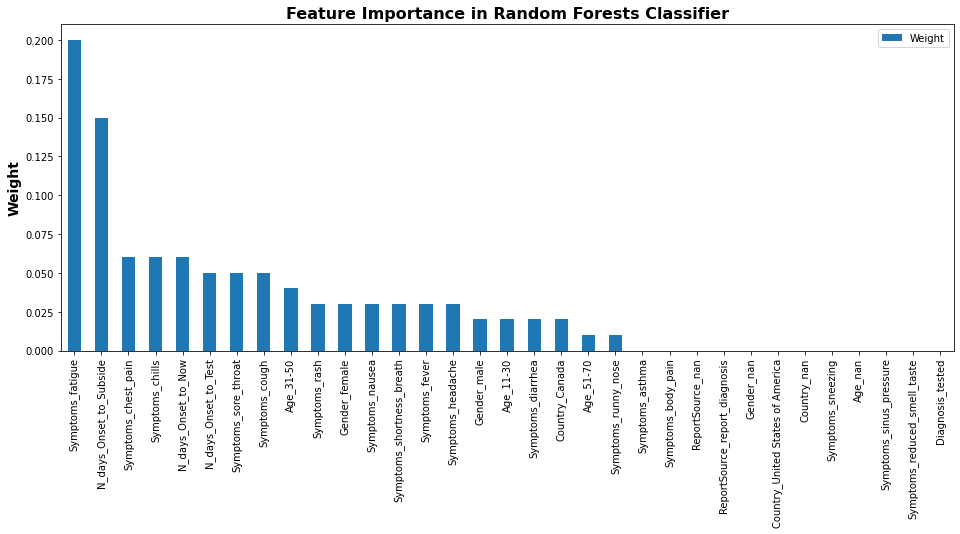

In [54]:
# Visualize
df_feature_importance.plot(kind="bar", figsize=(16,6))

# Set Labels
plt.title("Feature Importance in Random Forests Classifier", weight="bold", size=16)
plt.ylabel("Weight", weight="bold",size=14)

# Save
os.makedirs("output", exist_ok=True)
plt.savefig("output/Feature Importance in Random Forests Classifier.png", dpi=150, bbox_inches="tight")

# Display
plt.show()

## PCA + Linear Regression

In [ ]:
pca = PCA()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [17]:
from sklearn.ensemble import RandomForestClassifier